# PDS Cloud Pilot Study Preliminary Work

In [1]:
# Import packages
import glob
from datetime import datetime
from obspy.core import read
from matplotlib import pyplot as plt
import numpy as np
import os
import requests

In [3]:
# For now, we will select a single day file within our github directory for convenience
# There are three files in the directory, corresponding to the same day for a single instrument. 
# The three files correspond to the three recorded directions of motion (2 horizontal, one vertical)

testday_files = sorted(glob.glob(f'{datadir}*.mseed'))

## Alternate way of pulling the data using the PDS API

Pull the collection of data files, relevant for a given day, here as in the example "1970-084"

In [18]:
import pds.updart as upd

client = upd.PDSRegistryClient()

day = datetime.strptime("1970-084", "%Y-%j")
products = upd.Products(client).of_collection("urn:nasa:pds:apollo_pse:data_seed::1.0").after(day).before(day)

seismic_data_products = [p for p in products if p.properties["apollo:Seismic_Parameters.apollo:pse_data_type"][0] == "waveform"]
for p in seismic_data_products:
    print(p.id, p.properties["apollo:Seismic_Parameters.apollo:channel"][0], p.properties["ops:Data_File_Info.ops:file_ref"][0])

urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.083.0::1.0 ATT https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/083/xa.s12..att.1970.083.0.mseed
urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mh1.1970.083.0::1.0 MH1 https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/083/xa.s12.00.mh1.1970.083.0.mseed
urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mh2.1970.083.0::1.0 MH2 https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/083/xa.s12.00.mh2.1970.083.0.mseed
urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mhz.1970.083.0::1.0 MHZ https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/083/xa.s12.00.mhz.1970.083.0.mseed
urn:nasa:pds:apollo_pse:data_seed:xa.s12..att.1970.084.0::1.0 ATT https://pds-geosciences.wustl.edu/lunar/urn-nasa-pds-apollo_pse/data/xa/continuous_waveform/s12/1970/084/xa.s12..att.1970.

### Product details

Each product comes with a lot of metadata (originally managed in the PDS4 XML labels).

If needed for this use case, we could use these fields, especially, the properties specific to the apollo mission.


In [19]:
for k, v in p.properties.items():
    if k.startswith("apollo:"):
        print(k, v)

apollo:Observation_Information.apollo:product_type ['Mini-SEED']
apollo:ASCII_Equivalent.apollo:ascii_equivalent_file_name ['xa.s12.00.mhz.1970.084.0.a.csv']
apollo:Metadata_Location.apollo:metadata_file_name ['dataless.xa.0.seed']
apollo:Seismic_Parameters.apollo:sample_count ['572412']
apollo:Seismic_Parameters.apollo:location ['00']
apollo:Seismic_Parameters.apollo:station ['S12']
apollo:Seismic_Parameters.apollo:pse_data_type ['waveform']
apollo:Seismic_Parameters.apollo:channel ['MHZ']
apollo:Seismic_Parameters.apollo:sampling_rate ['6.625']


In [20]:
p.properties

{'pds:Modification_Detail.pds:description': ['First release to Planetary Data System'],
 'lid': ['urn:nasa:pds:apollo_pse:data_seed:xa.s12.00.mhz.1970.084.0'],
 'apollo:Observation_Information.apollo:product_type': ['Mini-SEED'],
 'pds:Modification_Detail.pds:modification_date': ['2022-07-17T00:00:00Z'],
 'ref_lid_instrument': ['urn:nasa:pds:context:instrument:pse.a12a'],
 'pds:Internal_Reference.pds:lidvid_reference': ['urn:nasa:pds:apollo_pse:data_table:xa.s12.00.mhz.1970.084.0.a::1.0'],
 'ops:Tracking_Meta.ops:archive_status': ['archived'],
 'ops:Label_File_Info.ops:md5_checksum': ['744c77d9b14e6857cf2a0c05c361248f'],
 'pds:File.pds:file_name': ['xa.s12.00.mhz.1970.084.0.mseed'],
 'product_class': ['Product_Native'],
 'vid': ['1.0'],
 'ref_lid_metadata': ['urn:nasa:pds:apollo_pse:data_seed:dataless.xa.0'],
 'pds:Time_Coordinates.pds:stop_date_time': ['1970-03-26T00:00:02.100377Z'],
 'ops:Provenance.ops:registry_sweepers_ancestry_version': ['3'],
 'apollo:ASCII_Equivalent.apollo:asci

# Test 1: Read in the raw data and plot it

In [4]:
def find_tracelen(infile):
    """
    Finds the length of the trace so we can pre-load the data matrix for analysis
    Also returns the start time of the file in datetime format
    
    :param infile: [str] Path to file to read
    """
    # Read the data as a stream and extract the trace
    st = read(infile)
    tr = st[0]
    
    return len(tr.data), tr.stats.starttime.datetime
    
def read_mseed(infile):
    """
    Reads in the data using the obspy utility and returns the time and velocity measurements
    
    :param infile: [str] Path to file to read
    """
    # Read the data as a stream and extract the trace
    st = read(infile)
    tr = st[0]
    
    return tr.times(), tr.data

# First, return the length of the data for this trace and find the start time of the file (it should be the same for all components)
len_trace, trace_start = find_tracelen(testday_files[0])

# Create the array and place the input values
# Make sure to save the channel names while we're cycling through
valdata_array_raw = np.zeros((len_trace, len(testday_files)))
channames = []

for infile_ind in np.arange(len(testday_files)):
    timedata, valdata = read_mseed(testday_files[infile_ind])
    valdata_array_raw[:, infile_ind] = valdata
    channames.append(os.path.basename(testday_files[infile_ind]).split('.')[3])
day = f'{trace_start.year}-{str(trace_start.month).zfill(2)}-{str(trace_start.day).zfill(2)}'    

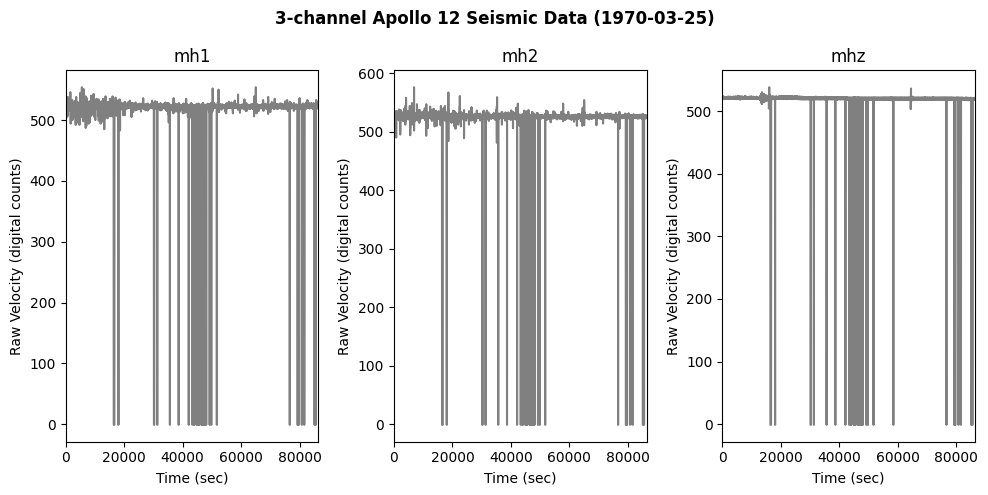

In [5]:
# Plot the raw data
fig = plt.figure(figsize=(10, 5))
for chan_ind in np.arange(np.shape(valdata_array_raw)[1]):
    # Plot the raw data
    ax0 = plt.subplot(1, np.shape(valdata_array_raw)[1], chan_ind+1)
    ax0.plot(timedata, valdata_array_raw[:, chan_ind], color='gray')
    ax0.set_xlim((timedata[0], timedata[-1]))
    ax0.set_title(f'{channames[chan_ind]}')
    ax0.set_xlabel('Time (sec)')
    ax0.set_ylabel('Raw Velocity (digital counts)')
fig.suptitle(f'3-channel Apollo 12 Seismic Data ({day})', fontweight='bold')
fig.tight_layout()
    

# Test 2: Process the data from machine counts to physical units

In [6]:
# Import some additional libraries
from obspy.signal.invsim import cosine_taper
from scipy.interpolate import interp1d
from obspy import read_inventory
import datetime as dt

In [7]:
# Import some subroutines required for the data processing
def running_median(seq, win):
    """
    Conducts a running median on the data

    :param seq: [Vector] Input data
    :param win: [Integer] Size of the window (in samples)
    """

    samples = np.arange(len(seq))
    medians = []

    window_middle = int(np.ceil(win / 2))

    for ind in np.arange(len(seq)):

        if ind <= window_middle:
            medians.append(np.median(abs(seq[0:win])))

        if ind >= len(seq) - window_middle:
            medians.append(np.median(abs(seq[len(seq) - win:len(seq)])))

        if window_middle < ind < len(seq) - window_middle:
            medians.append(np.median(abs(seq[ind - int(np.floor(win / 2)):ind + int(np.floor(win / 2))])))

    return np.array(medians)


def despike(input_t, input_d, fs):
    """
    Despikes the data according to Budlow 2005

    :param input_t: [Vector] Interpolated time
    :param input_d: [Vector] Interpolated data
    :param fs: [Float] Sampling frequency
    :param instrument_type: [String] Type of instrument [lp = long period, sp = short period]
    """

    # Compute a running median on the data
    # The window size should be 2 minutes (120 seconds) and odd
    window_size = int(fs * 120)
    if window_size % 2 == 0:
        window_size = window_size + 1
    med = running_median(input_d, window_size)

    # Find values greater than 5 times the running median
    med_multiplier = 5.
    indices_to_remove = []
    for ind in np.arange(len(input_d)):
        if input_d[ind] > abs(med[ind] * med_multiplier) or input_d[ind] < -1 * abs(med[ind] * med_multiplier):
            indices_to_remove.append(ind)

    # Remove those values from the time and data
    input_t_del = np.delete(input_t, indices_to_remove)
    input_d_del = np.delete(input_d, indices_to_remove)

    # If we remove the last value in the dat, we run into trouble because it can't finish interpolation
    # If it's missing, append a zero value to the data at the end. We have a total of four cases.
    # Missing beginning
    if not input_t_del[0] == input_t[0] and input_t_del[-1] == input_t[-1]:
        input_t_del_fin = np.insert(input_t_del, 0, input_t[0])
        input_d_del_fin = np.insert(input_d_del, 0, 0)

    # Missing end
    if input_t_del[0] == input_t[0] and not input_t_del[-1] == input_t[-1]:
        input_t_del_fin = np.append(input_t_del, input_t[-1])
        input_d_del_fin = np.append(input_d_del, 0)

    # Both missing
    if not input_t_del[0] == input_t[0] and not input_t_del[-1] == input_t[-1]:
        input_t_del_fixbeg = np.insert(input_t_del, 0, input_t[0])
        input_d_del_fixbeg = np.insert(input_d_del, 0, 0)
        input_t_del_fin = np.append(input_t_del_fixbeg, input_t[-1])
        input_d_del_fin = np.append(input_d_del_fixbeg, 0)

    # Nothing missing
    if input_t_del[0] == input_t[0] and input_t_del[-1] == input_t[-1]:
        input_t_del_fin = input_t_del
        input_d_del_fin = input_d_del

    # Interpolate over the missing values
    # We can call on our original input_t variable
    f2 = interp1d(input_t_del_fin, input_d_del_fin)
    d_interp2 = f2(input_t)

    return d_interp2

In [8]:
def process_data(indata, dataless_seed):
    """
    Processes the data: removes mean, tapers, and removes the instrument response (converting it to physical units)
    
    :param infile: [str] Path to file to read
    :param dataless_seed: [str] Path to the dataless seed, which is required for removing the instrument response
    """
    # Read the data as a stream and extract the trace
    st = read(indata)
    tr = st[0]
    
    # Remove the mean and run a cosine taper
    tr.data = tr.data - np.mean(tr.data)
    taper_function = cosine_taper(len(tr.data), p=0.02)
    tr.data = tr.data * taper_function

    # Set a bandpass filter and remove the instrument response
    # Note: This narrow filter is required for instrument response removal. Otherwise the low frequencies dominate the spectrum. 
    pre_filt = [0.1, 0.3, 0.9, 1.1]
    inv = read_inventory(dataless_seed)
    tr.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL",
                       water_level=None)

    # Interpolate and despike the data
    sr = 6.625
    delta_target = 1 / sr
    tm = tr.times()
    times_seconds_interp = np.arange(tm[0], tm[-1] - delta_target, delta_target)
    tm_utc = tr.times(type='utcdatetime')
    tm_num_interp = [tm_utc[0] + dt.timedelta(seconds=x) for x in
                        times_seconds_interp]

    f = interp1d(tm, tr.data)
    d_interp = f(times_seconds_interp)

    d_new = despike(times_seconds_interp, d_interp, 1 / delta_target)

    print(f'Processed file {os.path.basename(indata)}')

    return times_seconds_interp, d_new

# Pass the location of the dataless seed which contains the information for instrument response removal
dataless_seed = f'{rundir}dataless.xa.0.seed'

# Cycle through each file and process the data
for infile_ind in np.arange(len(testday_files)):
    proctime, procdata = process_data(testday_files[infile_ind], dataless_seed)

    # Since we are interpolating, the size of our data is going to be different, so we have to wait until the first interpolation to create the matrix
    procdata_len = len(procdata)

    if infile_ind == 0:
        valdata_array_proc = np.zeros((procdata_len, len(testday_files)))
    valdata_array_proc[:, infile_ind] = procdata
    

C:\Users\fcivilin\Anaconda3\envs\thermal\lib\site-packages\obspy\io\xseed\fields.py:373: UserWarning: Date is required.
  warnings.warn('Date is required.', UserWarning)


Processed file xa.s12.00.mh1.1970.084.0.mseed
Processed file xa.s12.00.mh2.1970.084.0.mseed
Processed file xa.s12.00.mhz.1970.084.0.mseed


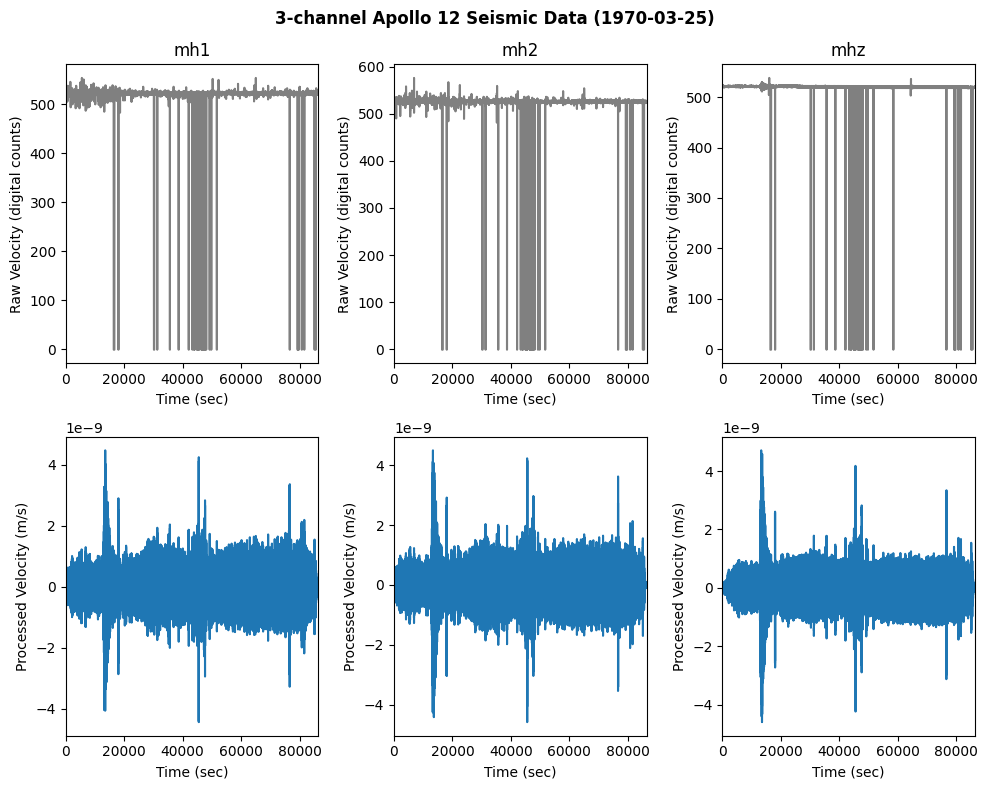

In [9]:
# Plot the result
fig = plt.figure(figsize=(10, 8))
for chan_ind in np.arange(np.shape(valdata_array_raw)[1]):
    # Plot the raw data
    ax0 = plt.subplot(2, np.shape(valdata_array_raw)[1], chan_ind+1)
    ax0.plot(timedata, valdata_array_raw[:, chan_ind], c='gray')
    ax0.set_xlim((timedata[0], timedata[-1]))
    ax0.set_title(f'{channames[chan_ind]}')
    ax0.set_xlabel('Time (sec)')
    ax0.set_ylabel('Raw Velocity (digital counts)')

    # Plot the processed data
    ax1 = plt.subplot(2, np.shape(valdata_array_raw)[1], chan_ind+4)
    ax1.plot(proctime, valdata_array_proc[:, chan_ind])
    ax1.set_xlim((proctime[0], proctime[-1]))
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Processed Velocity (m/s)')
fig.suptitle(f'3-channel Apollo 12 Seismic Data ({day})', fontweight='bold')
fig.tight_layout()

# Test 3: Compute Spectrograms for the data

In [10]:
# Import additional packages
from scipy import signal
from matplotlib import cm

In [11]:
# We are going to compute the seismic arrival time of an impact moonquake that occurs in this hour
# We use the term evid (event ID) to describe the arrival
# The format we will use for datetime is %Y-%m-%dT%H:%M:%S
arrival_absolute_str = '1970-03-25T3:32:00'
arrival_absolute_dt = dt.datetime.strptime(arrival_absolute_str, '%Y-%m-%dT%H:%M:%S')

# Convert it to the time in seconds after the start of the hour
arrival_rel = (arrival_absolute_dt - trace_start).seconds

In [12]:
def compute_spec(trtime, trvals):
    """
    Computes the spectrograms of the processed data

    :param trtime: [vector] Processed time values
    :param trvals: [vector] Processed velocity values
    """
    # Get the sample-rate of the processed data. If we don't have an explicit value saved, we can just use differences in the time vector
    delta_samples = trtime[1]-trtime[0]
    sampling_rate = 1/delta_samples
    
    # Compute spectrogram
    spec_f, spec_t, spec_sxx = signal.spectrogram(trvals, sampling_rate)
    
    return spec_f, spec_t, spec_sxx

# Cycle through each file 
for chanind in np.arange(np.shape(valdata_array_proc)[1]):
    spec_f, spec_t, spec_sxx = compute_spec(proctime, valdata_array_proc[:, chanind])

    # Create the output vector. Since it's an array instead of a vector, our final output needs to be a 3D array
    if chanind == 0:
        spec_array = np.zeros((np.shape(spec_sxx)[0], np.shape(spec_sxx)[1], len(testday_files)))
    spec_array[:, :, chanind] = spec_sxx

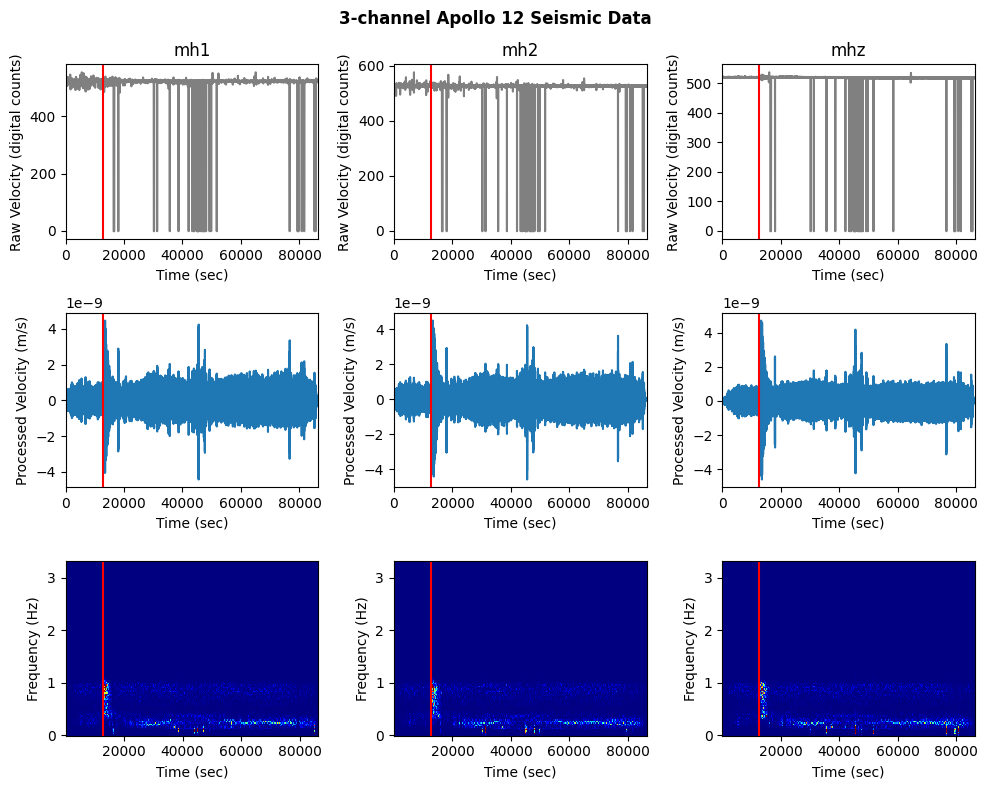

In [13]:
# Plot the result
fig = plt.figure(figsize=(10, 8))
for chan_ind in np.arange(np.shape(valdata_array_raw)[1]):
    # Plot the raw data
    ax0 = plt.subplot(3, np.shape(valdata_array_raw)[1], chan_ind+1)
    ax0.plot(timedata, valdata_array_raw[:, chan_ind], c='gray')
    ax0.set_xlim((timedata[0], timedata[-1]))
    ax0.set_title(f'{channames[chan_ind]}')
    ax0.set_xlabel('Time (sec)')
    ax0.set_ylabel('Raw Velocity (digital counts)')

    # Plot the processed data
    ax1 = plt.subplot(3, np.shape(valdata_array_raw)[1], chan_ind+4)
    ax1.plot(proctime, valdata_array_proc[:, chan_ind])
    ax1.set_xlim((proctime[0], proctime[-1]))
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Processed Velocity (m/s)')

    # Plot the spectrogram
    ax2 = plt.subplot(3, np.shape(valdata_array_raw)[1], chan_ind+7)
    ax2.pcolormesh(spec_t, spec_f, spec_sxx, cmap=cm.jet, vmax=5e-18)
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylabel('Frequency (Hz)')

    # Plot the arrivals
    ax0.axvline(arrival_rel, c='red')
    ax1.axvline(arrival_rel, c='red')
    ax2.axvline(arrival_rel, c='red')
    
fig.suptitle(f'3-channel Apollo 12 Seismic Data', fontweight='bold')
fig.tight_layout()

# Test 4: Cut and export the data

In [14]:
# Import more packages
from obspy import UTCDateTime

In [15]:
# Pick a trim length before and after the arrival (in seconds)
pre_arrival_time = 300
post_arrival_time = 5200

# Use the timedelta function to get the absolute datetime of when to cut the trace
pre_arrival_dt = arrival_absolute_dt - dt.timedelta(seconds=pre_arrival_time)
post_arrival_dt = arrival_absolute_dt + dt.timedelta(seconds=post_arrival_time)

# Obspy uses utctime, so use the UTCDateTime function to convert it to that format
pre_arrival_utc = UTCDateTime(pre_arrival_dt)
post_arrival_utc = UTCDateTime(post_arrival_dt)

In [16]:
# Set an output directory
outdir = f'{rundir}test_output/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# Cut the files
for chandir in np.arange(len(testday_files)):
    bname = os.path.basename(testday_files[chandir])
    st = read(testday_files[chandir])
    st.trim(pre_arrival_utc, post_arrival_utc)
    st.write(f'{outdir}{bname[0:-6]}_cut.mseed', format='MSEED')
    print(f'Cut file {bname[0:-6]}_cut.mseed...')

Cut file xa.s12.00.mh1.1970.084.0_cut.mseed...
Cut file xa.s12.00.mh2.1970.084.0_cut.mseed...
Cut file xa.s12.00.mhz.1970.084.0_cut.mseed...


In [17]:
# Get the cut files and plot their new raw values
cutfiles = sorted(glob.glob(f'{outdir}*.mseed'))

# Find their new cut length
cutlen_trace, cuttrace_start = find_tracelen(cutfiles[0])

# Add the values to a new raw array
valdata_array_rawcut = np.zeros((cutlen_trace, len(cutfiles)))
for infile_ind in np.arange(len(cutfiles)):
    timedata_cut, valdata_cut = read_mseed(cutfiles[infile_ind])
    valdata_array_rawcut[:, infile_ind] = valdata_cut

In [18]:
# Apply the same processing to the new files
for infile_ind in np.arange(len(cutfiles)):
    cuttime, cutdata = process_data(cutfiles[infile_ind], dataless_seed)

    # Since we are interpolating, the size of our data is going to be different, so we have to wait until the first interpolation to create the matrix
    cutdata_len = len(cutdata)

    if infile_ind == 0:
        valdata_array_cut = np.zeros((cutdata_len, len(cutfiles)))
    valdata_array_cut[:, infile_ind] = cutdata

Processed file xa.s12.00.mh1.1970.084.0_cut.mseed
Processed file xa.s12.00.mh2.1970.084.0_cut.mseed
Processed file xa.s12.00.mhz.1970.084.0_cut.mseed


In [19]:
# Compute the new spectrogram
for chanind in np.arange(np.shape(valdata_array_cut)[1]):
    speccut_f, speccut_t, speccut_sxx = compute_spec(cuttime, valdata_array_cut[:, chanind])

    # Create the output vector. Since it's an array instead of a vector, our final output needs to be a 3D array
    if chanind == 0:
        spec_array_cut = np.zeros((np.shape(speccut_sxx)[0], np.shape(speccut_sxx)[1], len(cutfiles)))
    spec_array_cut[:, :, chanind] = speccut_sxx

In [20]:
# Get the new relative seismic arrival time
arrival_relcut = (arrival_absolute_dt - cuttrace_start).seconds

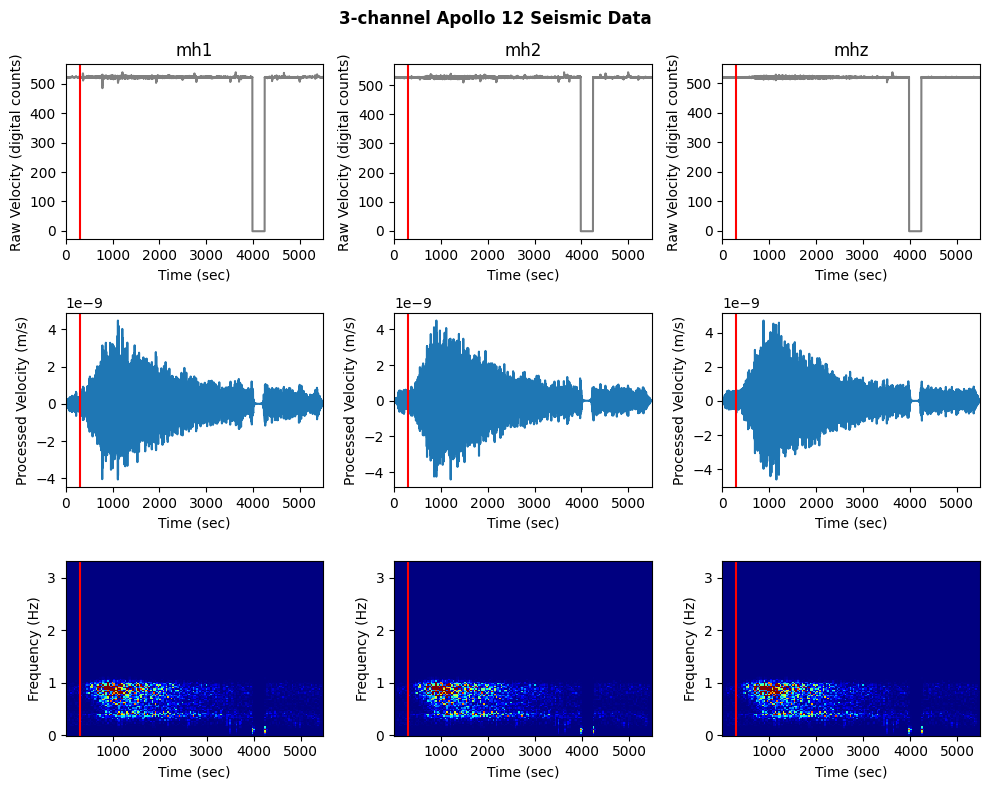

In [21]:
# Plot the result
fig = plt.figure(figsize=(10, 8))
for chan_ind in np.arange(np.shape(valdata_array_rawcut)[1]):
    # Plot the raw data
    ax0 = plt.subplot(3, np.shape(valdata_array_rawcut)[1], chan_ind+1)
    ax0.plot(timedata_cut, valdata_array_rawcut[:, chan_ind], c='gray')
    ax0.set_xlim((timedata_cut[0], timedata_cut[-1]))
    ax0.set_title(f'{channames[chan_ind]}')
    ax0.set_xlabel('Time (sec)')
    ax0.set_ylabel('Raw Velocity (digital counts)')

    # Plot the processed data
    ax1 = plt.subplot(3, np.shape(valdata_array_rawcut)[1], chan_ind+4)
    ax1.plot(cuttime, valdata_array_cut[:, chan_ind])
    ax1.set_xlim((cuttime[0], cuttime[-1]))
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Processed Velocity (m/s)')

    # Plot the spectrogram
    ax2 = plt.subplot(3, np.shape(valdata_array_rawcut)[1], chan_ind+7)
    ax2.pcolormesh(speccut_t, speccut_f, speccut_sxx, cmap=cm.jet, vmax=5e-18)
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylabel('Frequency (Hz)')

    # Plot the arrivals
    ax0.axvline(arrival_relcut, c='red')
    ax1.axvline(arrival_relcut, c='red')
    ax2.axvline(arrival_relcut, c='red')
    
fig.suptitle(f'3-channel Apollo 12 Seismic Data', fontweight='bold')
fig.tight_layout()